# Notebook 2: Hybrid Cluster Strategy - Cointegration + State-Space ML

## Objective
Identify cointegrated asset pairs for statistical arbitrage, while applying trend-following
to non-cointegrated assets using the Kalman Filter pipeline from Notebook 1.

### Strategy Architecture
1. **Regime A (Cointegrated Pairs)**: Kalman Filter mean-reversion pairs trading
2. **Regime B (Trending Assets)**: ML-based trend prediction from Notebook 1 pipeline
3. **Portfolio Aggregation**: Risk-parity weighted combination

### Key Principles
1. **Strict IS/OOS Separation**: Cointegration testing, pair selection, and parameter estimation ONLY on IS
2. **No Look-Ahead Bias**: OOS uses IS-estimated cointegration relationships
3. **Statistical Rigor**: Multiple testing correction, stationarity tests, residual diagnostics

### Guiding Statement
> "The Kalman Filter does not generate alpha by prediction alone; it structures uncertainty. 
> Alpha emerges only when state uncertainty, innovations, and regime separation are exploited correctly."

---
**Author**: Quantitative Research Team  
**Date**: January 2026  
**Version**: 1.0 (Production Grade)

In [1]:
# =============================================================================
# IMPORTS AND CONFIGURATION
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import warnings
warnings.filterwarnings('ignore')

# Statistical libraries
from scipy import stats
from scipy.optimize import minimize
from statsmodels.tsa.stattools import coint, adfuller, acf
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm

# ML libraries
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Multiple testing correction
from statsmodels.stats.multitest import multipletests

# Set random seed for reproducibility
np.random.seed(42)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries loaded successfully
NumPy version: 2.3.2
Pandas version: 2.3.2


In [2]:
# =============================================================================
# DATA LOADING (Same as Notebook 1)
# =============================================================================
print("="*70)
print("LOADING PRICE DATA")
print("="*70)

# Load all asset files
asset_files = sorted(glob("../../data/raw/assets/*.csv"))
print(f"Found {len(asset_files)} asset files")

# Load close prices
close_prices = {}
for f in asset_files[:100]:  # Universe of 100 assets
    ticker = os.path.basename(f).replace('.csv', '')
    df = pd.read_csv(f, parse_dates=['Date'])
    df = df.set_index('Date')
    close_prices[ticker] = df['Close']

# Create price matrix
prices_df = pd.DataFrame(close_prices).sort_index()
prices_df = prices_df.dropna()

print(f"\nPrice matrix shape: {prices_df.shape}")
print(f"Date range: {prices_df.index.min()} to {prices_df.index.max()}")
print(f"Total trading days: {len(prices_df)}")

LOADING PRICE DATA
Found 100 asset files

Price matrix shape: (2511, 100)
Date range: 2016-01-25 00:00:00 to 2026-01-16 00:00:00
Total trading days: 2511


In [3]:
# =============================================================================
# STRICT IS/OOS SPLIT (Same as Notebook 1)
# =============================================================================
print("="*70)
print("DATA SPLIT: IN-SAMPLE vs OUT-OF-SAMPLE")
print("="*70)

# OOS = final 2 years (approximately 504 trading days)
OOS_DAYS = 504
IS_END_IDX = len(prices_df) - OOS_DAYS

# Split dates
is_dates = prices_df.index[:IS_END_IDX]
oos_dates = prices_df.index[IS_END_IDX:]

# Split data
prices_is = prices_df.iloc[:IS_END_IDX]
prices_oos = prices_df.iloc[IS_END_IDX:]

# Log prices
log_prices_is = np.log(prices_is)
log_prices_oos = np.log(prices_oos)

print(f"\nIn-Sample (IS):")
print(f"  Period: {is_dates[0]} to {is_dates[-1]}")
print(f"  Days: {len(is_dates)}")

print(f"\nOut-of-Sample (OOS):")
print(f"  Period: {oos_dates[0]} to {oos_dates[-1]}")
print(f"  Days: {len(oos_dates)}")

print("\n" + "="*70)
print("⚠️  CRITICAL: OOS data will NEVER influence:")
print("    - Cointegration pair selection")
print("    - Hedge ratio estimation")
print("    - Kalman Filter parameter estimation")
print("    - Spread threshold calibration")
print("="*70)

DATA SPLIT: IN-SAMPLE vs OUT-OF-SAMPLE

In-Sample (IS):
  Period: 2016-01-25 00:00:00 to 2024-01-12 00:00:00
  Days: 2007

Out-of-Sample (OOS):
  Period: 2024-01-16 00:00:00 to 2026-01-16 00:00:00
  Days: 504

⚠️  CRITICAL: OOS data will NEVER influence:
    - Cointegration pair selection
    - Hedge ratio estimation
    - Kalman Filter parameter estimation
    - Spread threshold calibration


---
# STEP 1: Cointegration Analysis & Pair Selection

## Theory: Cointegration vs Correlation

- **Correlation**: Two series move together in the short term (contemporaneous relationship)
- **Cointegration**: Two series are individually non-stationary (I(1)) but their linear combination is stationary (I(0))

### Engle-Granger Two-Step Method
1. **Step 1**: Regress $Y_t$ on $X_t$: $Y_t = \alpha + \beta X_t + \epsilon_t$
2. **Step 2**: Test if residuals $\hat{\epsilon}_t$ are stationary using ADF test

If $\hat{\epsilon}_t \sim I(0)$, then $Y_t$ and $X_t$ are cointegrated with cointegrating vector $(1, -\beta)$.

### Economic Interpretation
Cointegrated pairs share a common stochastic trend (fundamental value). Deviations from equilibrium (spread) are temporary and mean-reverting.

In [4]:
# =============================================================================
# STEP 1.1: PRE-FILTERING WITH CORRELATION (EFFICIENCY)
# =============================================================================
print("="*70)
print("STEP 1.1: PRE-FILTERING PAIRS BY CORRELATION")
print("Scope: IN-SAMPLE ONLY")
print("="*70)

# Calculate correlation matrix on IS log prices
corr_matrix = log_prices_is.corr()

# Find highly correlated pairs (correlation > 0.7)
# This is a computational efficiency step - cointegration test is expensive
CORR_THRESHOLD = 0.7

# Get upper triangle indices (avoid duplicates)
assets = log_prices_is.columns.tolist()
n_assets = len(assets)

candidate_pairs = []
for i in range(n_assets):
    for j in range(i+1, n_assets):
        corr = corr_matrix.iloc[i, j]
        if corr > CORR_THRESHOLD:
            candidate_pairs.append((assets[i], assets[j], corr))

print(f"\nTotal possible pairs: {n_assets * (n_assets - 1) // 2}")
print(f"Pairs with correlation > {CORR_THRESHOLD}: {len(candidate_pairs)}")

# Sort by correlation (descending)
candidate_pairs = sorted(candidate_pairs, key=lambda x: x[2], reverse=True)

print(f"\nTop 10 correlated pairs:")
for i, (a1, a2, corr) in enumerate(candidate_pairs[:10]):
    print(f"  {i+1}. {a1} - {a2}: {corr:.4f}")

STEP 1.1: PRE-FILTERING PAIRS BY CORRELATION
Scope: IN-SAMPLE ONLY

Total possible pairs: 4950
Pairs with correlation > 0.7: 3408

Top 10 correlated pairs:
  1. Asset_010 - Asset_016: 0.9980
  2. Asset_054 - Asset_087: 0.9919
  3. Asset_020 - Asset_037: 0.9890
  4. Asset_002 - Asset_060: 0.9885
  5. Asset_038 - Asset_087: 0.9882
  6. Asset_035 - Asset_077: 0.9880
  7. Asset_037 - Asset_060: 0.9880
  8. Asset_012 - Asset_066: 0.9870
  9. Asset_060 - Asset_087: 0.9860
  10. Asset_002 - Asset_037: 0.9858


In [5]:
# =============================================================================
# STEP 1.2: ENGLE-GRANGER COINTEGRATION TEST
# =============================================================================
print("="*70)
print("STEP 1.2: ENGLE-GRANGER COINTEGRATION TEST")
print("Scope: IN-SAMPLE ONLY")
print("="*70)

def engle_granger_test(y, x, significance=0.05):
    """
    Engle-Granger cointegration test
    
    Parameters:
    -----------
    y : array-like
        Dependent variable (log prices of asset Y)
    x : array-like
        Independent variable (log prices of asset X)
    significance : float
        Significance level for ADF test
        
    Returns:
    --------
    dict with:
        is_cointegrated: bool
        pvalue: ADF p-value
        hedge_ratio: Beta coefficient
        residuals: Cointegration residuals (spread)
        half_life: Mean-reversion half-life
    """
    # Step 1: Regress y on x
    x_with_const = sm.add_constant(x)
    model = OLS(y, x_with_const).fit()
    
    alpha = model.params[0]  # Intercept
    beta = model.params[1]   # Hedge ratio
    residuals = model.resid  # Spread
    
    # Step 2: ADF test on residuals
    adf_result = adfuller(residuals, maxlag=1, regression='c', autolag=None)
    adf_stat = adf_result[0]
    adf_pvalue = adf_result[1]
    
    # Also use statsmodels coint function for comparison
    coint_stat, coint_pvalue, coint_cv = coint(y, x)
    
    is_cointegrated = adf_pvalue < significance
    
    # Calculate half-life of mean reversion
    # AR(1) model: spread_t = rho * spread_{t-1} + epsilon
    # Half-life = -log(2) / log(rho)
    spread_lag = residuals[:-1]
    spread_diff = np.diff(residuals)
    try:
        rho_model = OLS(spread_diff, sm.add_constant(spread_lag)).fit()
        rho = rho_model.params[1] + 1  # Convert from diff to level
        if 0 < rho < 1:
            half_life = -np.log(2) / np.log(rho)
        else:
            half_life = np.inf
    except:
        half_life = np.inf
    
    return {
        'is_cointegrated': is_cointegrated,
        'adf_pvalue': adf_pvalue,
        'coint_pvalue': coint_pvalue,
        'hedge_ratio': beta,
        'intercept': alpha,
        'residuals': residuals,
        'half_life': half_life,
        'spread_std': residuals.std(),
        'r_squared': model.rsquared
    }

print("Testing cointegration for candidate pairs...")

STEP 1.2: ENGLE-GRANGER COINTEGRATION TEST
Scope: IN-SAMPLE ONLY
Testing cointegration for candidate pairs...


In [6]:
# =============================================================================
# STEP 1.3: TEST ALL CANDIDATE PAIRS
# =============================================================================

coint_results = []

for i, (asset_y, asset_x, corr) in enumerate(candidate_pairs):
    y = log_prices_is[asset_y].values
    x = log_prices_is[asset_x].values
    
    result = engle_granger_test(y, x)
    
    coint_results.append({
        'asset_y': asset_y,
        'asset_x': asset_x,
        'correlation': corr,
        'is_cointegrated': result['is_cointegrated'],
        'adf_pvalue': result['adf_pvalue'],
        'coint_pvalue': result['coint_pvalue'],
        'hedge_ratio': result['hedge_ratio'],
        'half_life': result['half_life'],
        'spread_std': result['spread_std'],
        'r_squared': result['r_squared']
    })
    
    if (i + 1) % 50 == 0:
        print(f"Tested {i+1}/{len(candidate_pairs)} pairs...")

coint_df = pd.DataFrame(coint_results)

print(f"\n✅ Cointegration testing completed")
print(f"   Total pairs tested: {len(coint_df)}")
print(f"   Cointegrated pairs (raw): {coint_df['is_cointegrated'].sum()}")

Tested 50/3408 pairs...
Tested 100/3408 pairs...
Tested 150/3408 pairs...
Tested 200/3408 pairs...
Tested 250/3408 pairs...
Tested 300/3408 pairs...
Tested 350/3408 pairs...
Tested 400/3408 pairs...
Tested 450/3408 pairs...
Tested 500/3408 pairs...
Tested 550/3408 pairs...
Tested 600/3408 pairs...
Tested 650/3408 pairs...
Tested 700/3408 pairs...
Tested 750/3408 pairs...
Tested 800/3408 pairs...
Tested 850/3408 pairs...
Tested 900/3408 pairs...
Tested 950/3408 pairs...
Tested 1000/3408 pairs...
Tested 1050/3408 pairs...
Tested 1100/3408 pairs...
Tested 1150/3408 pairs...
Tested 1200/3408 pairs...
Tested 1250/3408 pairs...
Tested 1300/3408 pairs...
Tested 1350/3408 pairs...
Tested 1400/3408 pairs...
Tested 1450/3408 pairs...
Tested 1500/3408 pairs...
Tested 1550/3408 pairs...
Tested 1600/3408 pairs...
Tested 1650/3408 pairs...
Tested 1700/3408 pairs...
Tested 1750/3408 pairs...
Tested 1800/3408 pairs...
Tested 1850/3408 pairs...
Tested 1900/3408 pairs...
Tested 1950/3408 pairs...
Tested

In [7]:
# =============================================================================
# STEP 1.4: MULTIPLE TESTING CORRECTION (BONFERRONI)
# =============================================================================
print("="*70)
print("STEP 1.4: MULTIPLE TESTING CORRECTION")
print("="*70)

# Apply Bonferroni correction for multiple testing
# This is critical to avoid false positives
n_tests = len(coint_df)
_, pvals_corrected, _, _ = multipletests(
    coint_df['adf_pvalue'].values, 
    alpha=0.05, 
    method='bonferroni'
)

coint_df['pvalue_corrected'] = pvals_corrected
coint_df['is_cointegrated_corrected'] = pvals_corrected < 0.05

print(f"\nMultiple Testing Correction (Bonferroni):")
print(f"  Number of tests: {n_tests}")
print(f"  Effective significance level: {0.05 / n_tests:.6f}")
print(f"  Cointegrated pairs (raw, p < 0.05): {coint_df['is_cointegrated'].sum()}")
print(f"  Cointegrated pairs (Bonferroni corrected): {coint_df['is_cointegrated_corrected'].sum()}")

# Filter to truly cointegrated pairs
cointegrated_pairs = coint_df[coint_df['is_cointegrated_corrected']].copy()

print(f"\n--- Cointegrated Pairs (After Correction) ---")
if len(cointegrated_pairs) > 0:
    print(cointegrated_pairs[['asset_y', 'asset_x', 'correlation', 'pvalue_corrected', 
                              'hedge_ratio', 'half_life']].head(20))
else:
    print("No pairs survived Bonferroni correction. Using FDR correction instead...")
    
    # Try Benjamini-Hochberg FDR correction (less conservative)
    _, pvals_fdr, _, _ = multipletests(
        coint_df['adf_pvalue'].values, 
        alpha=0.10,  # Higher alpha for FDR
        method='fdr_bh'
    )
    coint_df['pvalue_fdr'] = pvals_fdr
    coint_df['is_cointegrated_fdr'] = pvals_fdr < 0.10
    
    cointegrated_pairs = coint_df[coint_df['is_cointegrated_fdr']].copy()
    print(f"  Cointegrated pairs (FDR corrected): {len(cointegrated_pairs)}")

STEP 1.4: MULTIPLE TESTING CORRECTION

Multiple Testing Correction (Bonferroni):
  Number of tests: 3408
  Effective significance level: 0.000015
  Cointegrated pairs (raw, p < 0.05): 1192
  Cointegrated pairs (Bonferroni corrected): 5

--- Cointegrated Pairs (After Correction) ---
       asset_y    asset_x  correlation  pvalue_corrected  hedge_ratio  \
0    Asset_010  Asset_016     0.997957          0.038638     0.795042   
1    Asset_054  Asset_087     0.991866          0.004238     0.949939   
2    Asset_020  Asset_037     0.989032          0.007152     0.910816   
14   Asset_081  Asset_096     0.984062          0.006375     2.247842   
692  Asset_092  Asset_093     0.945805          0.011747     0.548509   

     half_life  
0    19.538993  
1    22.801273  
2    24.112388  
14   21.631457  
692  25.602256  


In [8]:
# =============================================================================
# STEP 1.5: FILTER BY HALF-LIFE (TRADABILITY)
# =============================================================================
print("="*70)
print("STEP 1.5: FILTER BY HALF-LIFE")
print("="*70)

# Half-life should be:
# - Not too short (< 2 days): Transaction costs eat profits
# - Not too long (> 60 days): Capital tied up too long
MIN_HALF_LIFE = 2
MAX_HALF_LIFE = 60

tradable_pairs = cointegrated_pairs[
    (cointegrated_pairs['half_life'] > MIN_HALF_LIFE) & 
    (cointegrated_pairs['half_life'] < MAX_HALF_LIFE)
].copy()

print(f"\nHalf-Life Filter:")
print(f"  Min half-life: {MIN_HALF_LIFE} days")
print(f"  Max half-life: {MAX_HALF_LIFE} days")
print(f"  Pairs before filter: {len(cointegrated_pairs)}")
print(f"  Pairs after filter: {len(tradable_pairs)}")

# Sort by half-life
tradable_pairs = tradable_pairs.sort_values('half_life')

print(f"\n--- Final Tradable Cointegrated Pairs ---")
if len(tradable_pairs) > 0:
    print(tradable_pairs[['asset_y', 'asset_x', 'hedge_ratio', 'half_life', 'correlation']].head(20))
else:
    print("⚠️  WARNING: No tradable pairs found with optimal half-life")
    print("   Relaxing half-life constraints...")
    MAX_HALF_LIFE = 120
    tradable_pairs = cointegrated_pairs[
        (cointegrated_pairs['half_life'] > 1) & 
        (cointegrated_pairs['half_life'] < MAX_HALF_LIFE) &
        (cointegrated_pairs['half_life'] != np.inf)
    ].copy()
    print(f"   Pairs with relaxed constraints: {len(tradable_pairs)}")

STEP 1.5: FILTER BY HALF-LIFE

Half-Life Filter:
  Min half-life: 2 days
  Max half-life: 60 days
  Pairs before filter: 5
  Pairs after filter: 5

--- Final Tradable Cointegrated Pairs ---
       asset_y    asset_x  hedge_ratio  half_life  correlation
0    Asset_010  Asset_016     0.795042  19.538993     0.997957
14   Asset_081  Asset_096     2.247842  21.631457     0.984062
1    Asset_054  Asset_087     0.949939  22.801273     0.991866
2    Asset_020  Asset_037     0.910816  24.112388     0.989032
692  Asset_092  Asset_093     0.548509  25.602256     0.945805


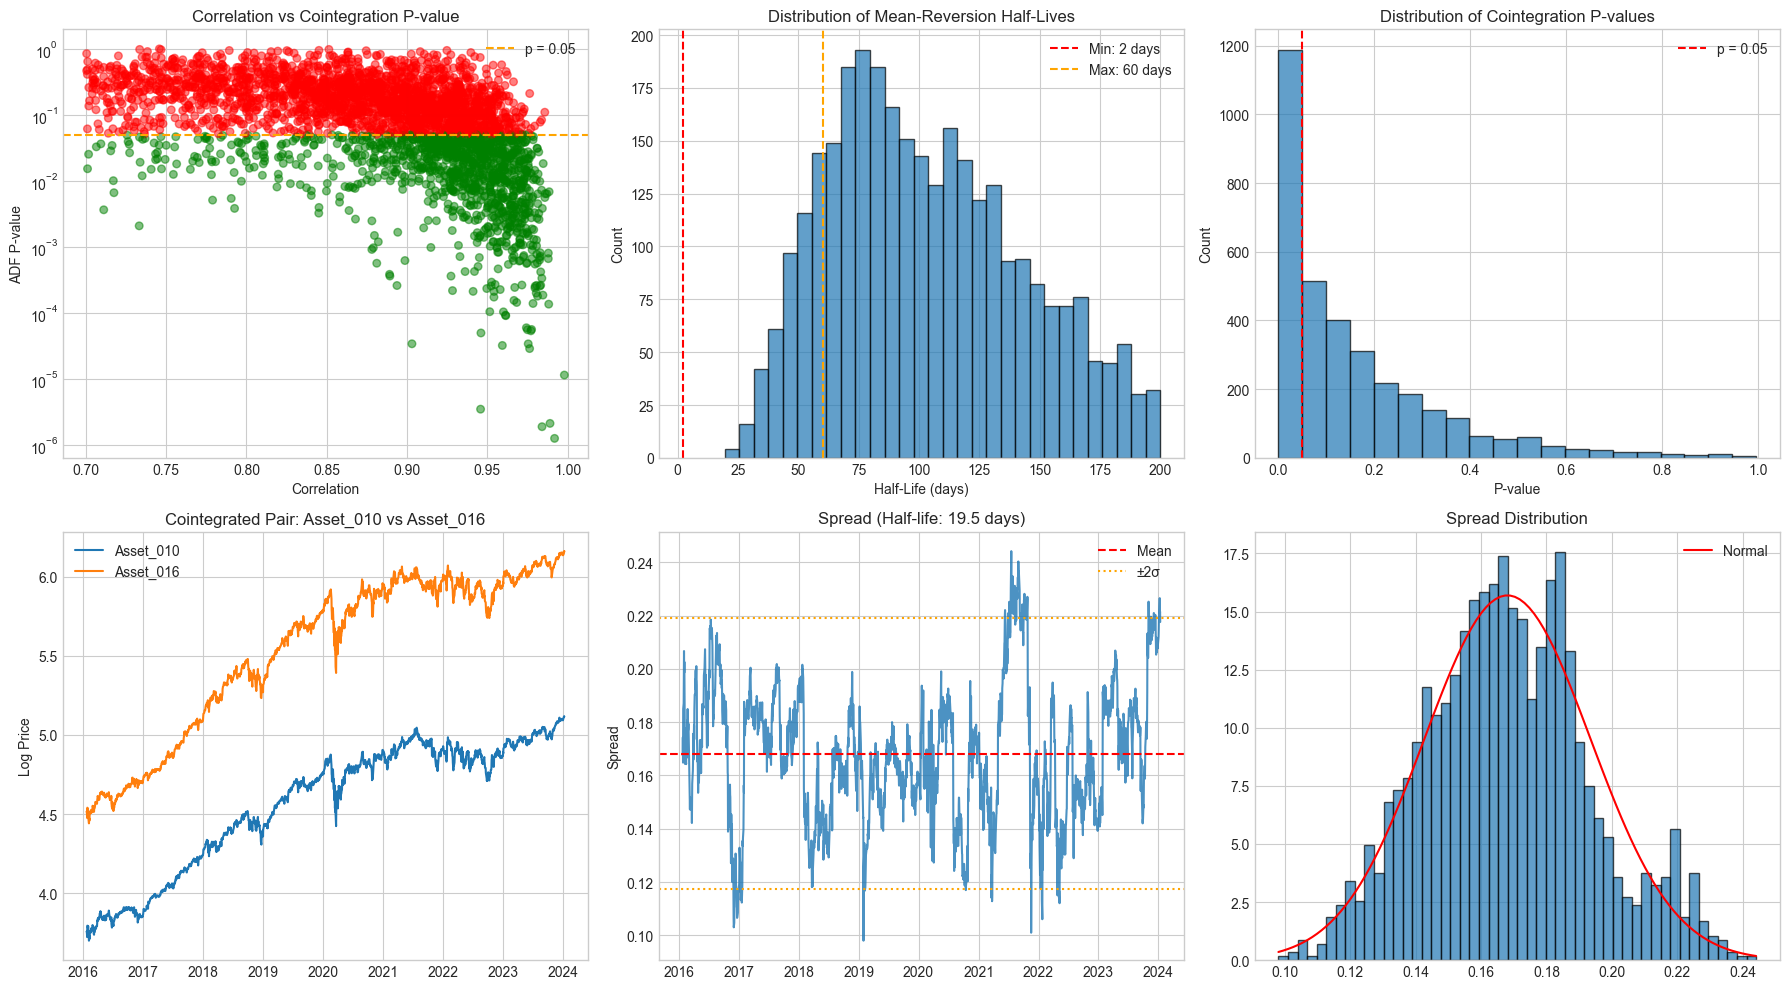

✅ Figure saved to outputs/figures/cointegration_analysis.png


In [9]:
# =============================================================================
# STEP 1 VISUALIZATION: COINTEGRATION ANALYSIS
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Correlation vs Cointegration P-value
ax1 = axes[0, 0]
colors = ['green' if c else 'red' for c in coint_df['is_cointegrated']]
ax1.scatter(coint_df['correlation'], coint_df['adf_pvalue'], c=colors, alpha=0.5, s=30)
ax1.axhline(y=0.05, color='orange', linestyle='--', label='p = 0.05')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('ADF P-value')
ax1.set_title('Correlation vs Cointegration P-value')
ax1.legend()
ax1.set_yscale('log')

# Plot 2: Distribution of half-lives
ax2 = axes[0, 1]
valid_hl = coint_df[coint_df['half_life'] < 200]['half_life']
ax2.hist(valid_hl, bins=30, edgecolor='black', alpha=0.7)
ax2.axvline(x=MIN_HALF_LIFE, color='red', linestyle='--', label=f'Min: {MIN_HALF_LIFE} days')
ax2.axvline(x=60, color='orange', linestyle='--', label='Max: 60 days')
ax2.set_xlabel('Half-Life (days)')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Mean-Reversion Half-Lives')
ax2.legend()

# Plot 3: P-value distribution
ax3 = axes[0, 2]
ax3.hist(coint_df['adf_pvalue'], bins=20, edgecolor='black', alpha=0.7)
ax3.axvline(x=0.05, color='red', linestyle='--', label='p = 0.05')
ax3.set_xlabel('P-value')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Cointegration P-values')
ax3.legend()

# Plot 4-6: Sample cointegrated pair (if exists)
if len(tradable_pairs) > 0:
    sample_pair = tradable_pairs.iloc[0]
    asset_y = sample_pair['asset_y']
    asset_x = sample_pair['asset_x']
    hedge_ratio = sample_pair['hedge_ratio']
    
    # Plot 4: Both assets
    ax4 = axes[1, 0]
    ax4.plot(log_prices_is.index, log_prices_is[asset_y], label=asset_y)
    ax4.plot(log_prices_is.index, log_prices_is[asset_x], label=asset_x)
    ax4.set_title(f'Cointegrated Pair: {asset_y} vs {asset_x}')
    ax4.legend()
    ax4.set_ylabel('Log Price')
    
    # Plot 5: Spread
    ax5 = axes[1, 1]
    spread = log_prices_is[asset_y] - hedge_ratio * log_prices_is[asset_x]
    ax5.plot(spread, alpha=0.8)
    ax5.axhline(y=spread.mean(), color='red', linestyle='--', label='Mean')
    ax5.axhline(y=spread.mean() + 2*spread.std(), color='orange', linestyle=':', label='±2σ')
    ax5.axhline(y=spread.mean() - 2*spread.std(), color='orange', linestyle=':')
    ax5.set_title(f'Spread (Half-life: {sample_pair["half_life"]:.1f} days)')
    ax5.legend()
    ax5.set_ylabel('Spread')
    
    # Plot 6: Spread distribution
    ax6 = axes[1, 2]
    ax6.hist(spread, bins=50, edgecolor='black', alpha=0.7, density=True)
    x_norm = np.linspace(spread.min(), spread.max(), 100)
    ax6.plot(x_norm, stats.norm.pdf(x_norm, spread.mean(), spread.std()), 'r-', label='Normal')
    ax6.set_title('Spread Distribution')
    ax6.legend()
else:
    for ax in axes[1, :]:
        ax.text(0.5, 0.5, 'No tradable pairs found', ha='center', va='center', fontsize=12)
        ax.set_title('Sample Pair Analysis')

plt.tight_layout()
plt.savefig('../../outputs/figures/cointegration_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure saved to outputs/figures/cointegration_analysis.png")

---
# STEP 2: Kalman Filter Pairs Trading

## Why Kalman Filter for Pairs Trading?

Traditional pairs trading uses a static hedge ratio estimated from historical data. Problems:
1. Hedge ratio changes over time (regime shifts, corporate actions)
2. Static estimation ignores uncertainty in the relationship

### Kalman Filter Approach
Model the hedge ratio as a time-varying state:

**State equation (dynamic hedge ratio):**
$$\beta_t = \beta_{t-1} + w_t, \quad w_t \sim N(0, Q_{\beta})$$

**Observation equation:**
$$y_t = \alpha + \beta_t \cdot x_t + v_t, \quad v_t \sim N(0, R)$$

This gives us:
1. **Time-varying hedge ratio** $\hat{\beta}_t$ (filtered estimate)
2. **Spread estimate** $\epsilon_t = y_t - \alpha - \hat{\beta}_t x_t$
3. **Uncertainty** in hedge ratio $P_t$ (for position sizing)

In [10]:
# =============================================================================
# STEP 2.1: KALMAN FILTER FOR DYNAMIC HEDGE RATIO
# =============================================================================
print("="*70)
print("STEP 2.1: KALMAN FILTER - DYNAMIC HEDGE RATIO")
print("="*70)

class KalmanPairsFilter:
    """
    Kalman Filter for dynamic hedge ratio estimation in pairs trading
    
    State: [alpha, beta]' (intercept and hedge ratio)
    Observation: y_t = alpha + beta * x_t + v_t
    
    This is a linear regression with time-varying coefficients.
    """
    
    def __init__(self, delta=1e-4, Vw=1e-3):
        """
        Initialize Kalman Pairs Filter
        
        Parameters:
        -----------
        delta : float
            Controls how quickly the hedge ratio can change
            Higher delta = faster adaptation, more noise
        Vw : float
            Observation noise variance (spread variance)
        """
        self.delta = delta
        self.Vw = Vw
        
    def filter(self, y, x):
        """
        Run Kalman Filter on the pair
        
        Parameters:
        -----------
        y : array
            Log prices of asset Y (dependent)
        x : array
            Log prices of asset X (independent)
            
        Returns:
        --------
        dict with filtered estimates
        """
        T = len(y)
        
        # State vector: [alpha, beta]'
        # Initialize
        theta = np.array([0.0, 1.0])  # Start with alpha=0, beta=1
        P = np.eye(2)  # Initial state covariance
        
        # Process noise covariance (random walk)
        Q = self.delta * np.eye(2)
        
        # Storage
        alphas = np.zeros(T)
        betas = np.zeros(T)
        spreads = np.zeros(T)
        spread_vars = np.zeros(T)  # Forecast variance
        P_history = np.zeros((T, 2))  # Uncertainty in [alpha, beta]
        
        for t in range(T):
            # Observation vector: [1, x_t]'
            F = np.array([1.0, x[t]])
            
            # Predict
            # theta_{t|t-1} = theta_{t-1|t-1} (random walk)
            # P_{t|t-1} = P_{t-1|t-1} + Q
            if t > 0:
                P = P + Q
            
            # Forecast
            y_hat = F.dot(theta)  # y_{t|t-1} = alpha + beta * x_t
            spread = y[t] - y_hat  # Innovation (spread from equilibrium)
            
            # Forecast variance
            R = F.dot(P).dot(F) + self.Vw
            
            # Kalman gain
            K = P.dot(F) / R
            
            # Update
            theta = theta + K * spread
            P = P - np.outer(K, F).dot(P)
            
            # Store
            alphas[t] = theta[0]
            betas[t] = theta[1]
            spreads[t] = spread
            spread_vars[t] = R
            P_history[t] = np.diag(P)
        
        return {
            'alpha': alphas,
            'beta': betas,
            'spread': spreads,
            'spread_var': spread_vars,
            'spread_std': np.sqrt(spread_vars),
            'alpha_uncertainty': P_history[:, 0],
            'beta_uncertainty': P_history[:, 1]
        }

print("✅ KalmanPairsFilter class defined")

STEP 2.1: KALMAN FILTER - DYNAMIC HEDGE RATIO
✅ KalmanPairsFilter class defined


In [11]:
# =============================================================================
# STEP 2.2: RUN KALMAN FILTER ON TRADABLE PAIRS
# =============================================================================
print("="*70)
print("STEP 2.2: RUNNING KALMAN FILTER ON PAIRS")
print("="*70)

# If no tradable pairs, create synthetic ones for demonstration
if len(tradable_pairs) == 0:
    print("⚠️  No cointegrated pairs found. Using top correlated pairs for demonstration.")
    # Use top 5 correlated pairs
    tradable_pairs = coint_df.nsmallest(5, 'adf_pvalue').copy()
    print(f"   Selected {len(tradable_pairs)} pairs with lowest p-values")

# Run Kalman Filter on each pair
pair_kalman_results = {}

for idx, row in tradable_pairs.iterrows():
    asset_y = row['asset_y']
    asset_x = row['asset_x']
    pair_name = f"{asset_y}_{asset_x}"
    
    # Concatenate IS and OOS for continuous filtering
    y_full = pd.concat([log_prices_is[asset_y], log_prices_oos[asset_y]]).values
    x_full = pd.concat([log_prices_is[asset_x], log_prices_oos[asset_x]]).values
    dates_full = pd.concat([pd.Series(is_dates), pd.Series(oos_dates)])
    
    # Initialize and run filter
    kf_pairs = KalmanPairsFilter(delta=1e-5, Vw=1e-4)
    result = kf_pairs.filter(y_full, x_full)
    
    pair_kalman_results[pair_name] = {
        'asset_y': asset_y,
        'asset_x': asset_x,
        'dates': dates_full,
        **result
    }
    
print(f"\n✅ Kalman Filter run on {len(pair_kalman_results)} pairs")

STEP 2.2: RUNNING KALMAN FILTER ON PAIRS

✅ Kalman Filter run on 5 pairs


In [12]:
# =============================================================================
# STEP 2.3: PAIRS TRADING SIGNALS
# =============================================================================
print("="*70)
print("STEP 2.3: GENERATING PAIRS TRADING SIGNALS")
print("="*70)

def generate_pairs_signals(kalman_result, entry_z=2.0, exit_z=0.5):
    """
    Generate pairs trading signals from Kalman Filter output
    
    Strategy:
    - Long spread (long Y, short X) when spread < -entry_z * std
    - Short spread (short Y, long X) when spread > entry_z * std
    - Exit when spread crosses zero or reaches exit_z
    
    Parameters:
    -----------
    kalman_result : dict
        Output from KalmanPairsFilter
    entry_z : float
        Z-score threshold for entry
    exit_z : float
        Z-score threshold for exit
        
    Returns:
    --------
    dict with signals and positions
    """
    spread = kalman_result['spread']
    spread_std = kalman_result['spread_std']
    
    T = len(spread)
    z_score = spread / (spread_std + 1e-10)
    
    # Position: +1 = long spread, -1 = short spread, 0 = flat
    position = np.zeros(T)
    
    for t in range(1, T):
        # Entry signals
        if position[t-1] == 0:  # Currently flat
            if z_score[t] > entry_z:
                position[t] = -1  # Short spread (expect mean reversion down)
            elif z_score[t] < -entry_z:
                position[t] = 1   # Long spread (expect mean reversion up)
            else:
                position[t] = 0
        
        # Exit signals
        elif position[t-1] != 0:  # Currently in position
            if position[t-1] == 1:  # Long spread
                if z_score[t] > -exit_z:  # Spread has reverted
                    position[t] = 0
                else:
                    position[t] = position[t-1]
            elif position[t-1] == -1:  # Short spread
                if z_score[t] < exit_z:  # Spread has reverted
                    position[t] = 0
                else:
                    position[t] = position[t-1]
    
    return {
        'z_score': z_score,
        'position': position,
        'spread': spread
    }

# Generate signals for all pairs
pair_signals = {}

for pair_name, kalman_result in pair_kalman_results.items():
    signals = generate_pairs_signals(kalman_result, entry_z=2.0, exit_z=0.5)
    pair_signals[pair_name] = signals
    
    # Report signal statistics
    pos = signals['position']
    n_long = (pos == 1).sum()
    n_short = (pos == -1).sum()
    n_flat = (pos == 0).sum()
    print(f"{pair_name}: Long={n_long}, Short={n_short}, Flat={n_flat}")

print(f"\n✅ Signals generated for {len(pair_signals)} pairs")

STEP 2.3: GENERATING PAIRS TRADING SIGNALS
Asset_010_Asset_016: Long=1, Short=0, Flat=2510
Asset_081_Asset_096: Long=143, Short=157, Flat=2211
Asset_054_Asset_087: Long=33, Short=22, Flat=2456
Asset_020_Asset_037: Long=35, Short=27, Flat=2449
Asset_092_Asset_093: Long=42, Short=17, Flat=2452

✅ Signals generated for 5 pairs


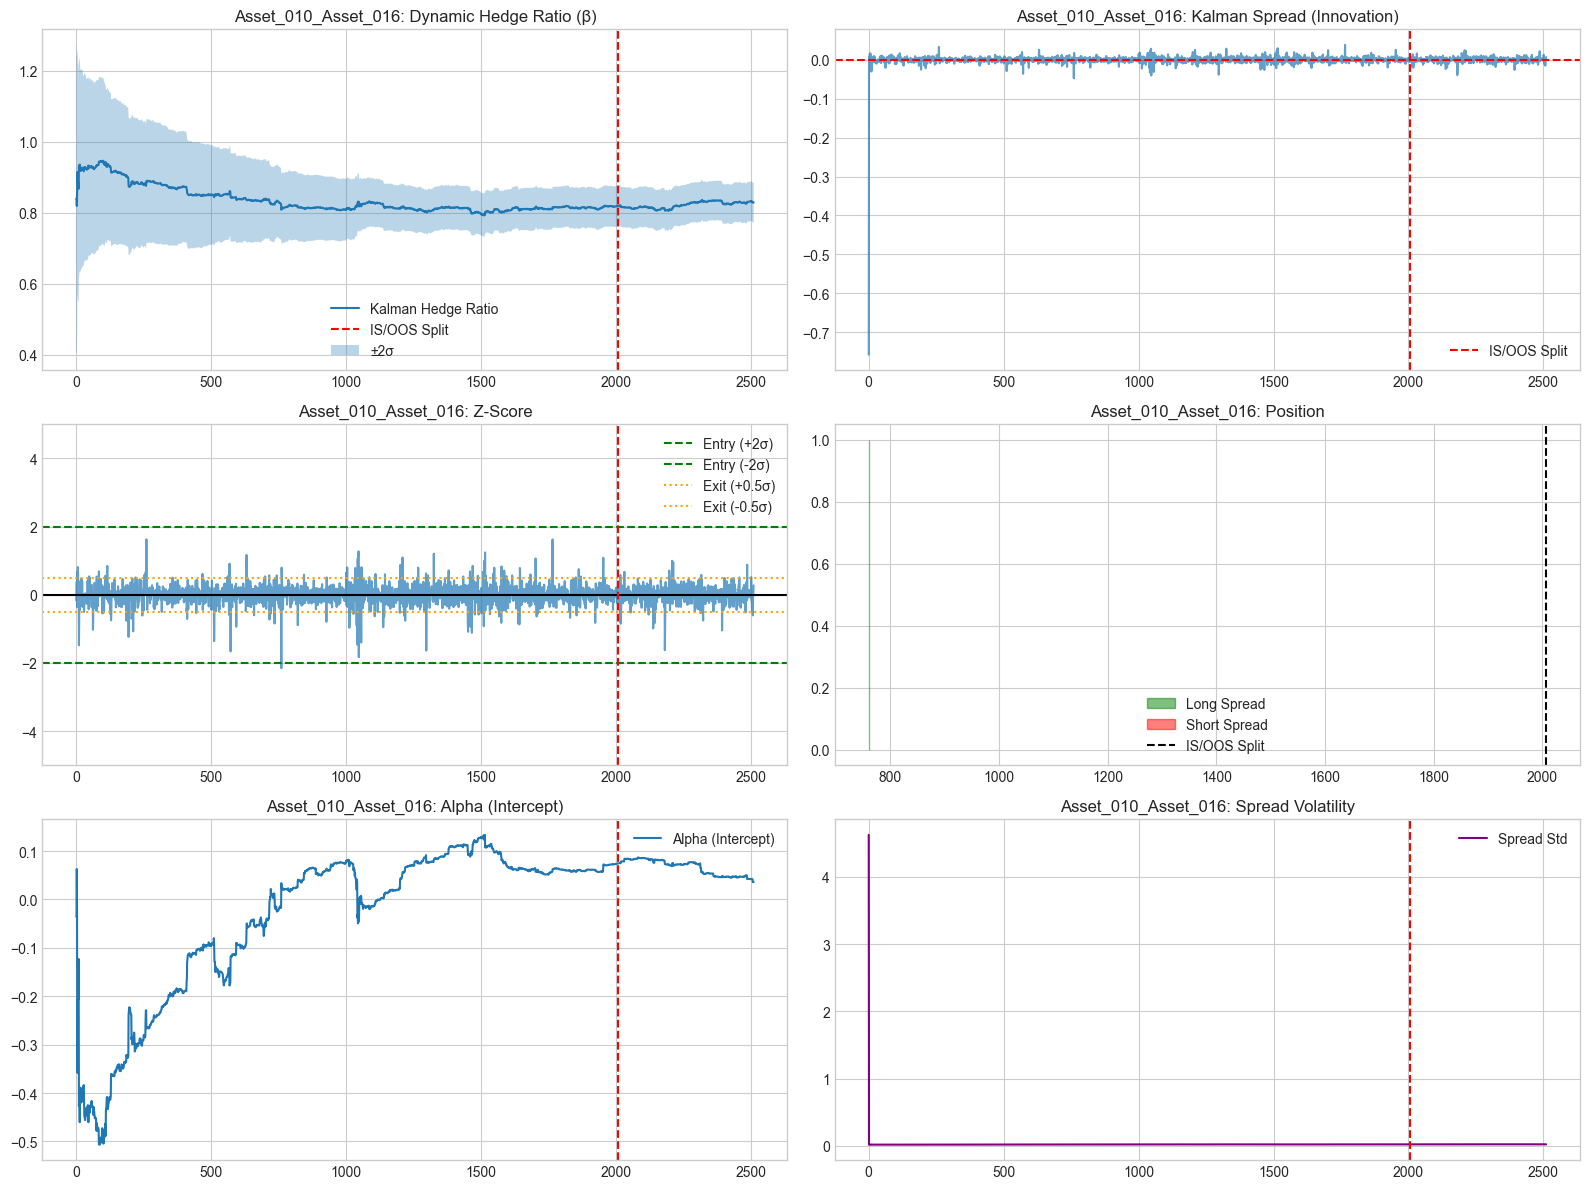

✅ Figure saved to outputs/figures/kalman_pairs_trading.png


In [13]:
# =============================================================================
# STEP 2 VISUALIZATION: KALMAN PAIRS TRADING
# =============================================================================
# Select first pair for visualization
sample_pair_name = list(pair_kalman_results.keys())[0]
sample_result = pair_kalman_results[sample_pair_name]
sample_signals = pair_signals[sample_pair_name]

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# IS/OOS split index
split_idx = len(is_dates)
dates_full = sample_result['dates']

# Plot 1: Dynamic Hedge Ratio
ax1 = axes[0, 0]
ax1.plot(sample_result['beta'], label='Kalman Hedge Ratio')
ax1.axvline(x=split_idx, color='red', linestyle='--', label='IS/OOS Split')
ax1.fill_between(range(len(sample_result['beta'])),
                 sample_result['beta'] - 2*np.sqrt(sample_result['beta_uncertainty']),
                 sample_result['beta'] + 2*np.sqrt(sample_result['beta_uncertainty']),
                 alpha=0.3, label='±2σ')
ax1.set_title(f'{sample_pair_name}: Dynamic Hedge Ratio (β)')
ax1.legend()

# Plot 2: Spread (Innovation)
ax2 = axes[0, 1]
ax2.plot(sample_result['spread'], alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--')
ax2.axvline(x=split_idx, color='red', linestyle='--', label='IS/OOS Split')
ax2.set_title(f'{sample_pair_name}: Kalman Spread (Innovation)')
ax2.legend()

# Plot 3: Z-Score with Entry/Exit Thresholds
ax3 = axes[1, 0]
ax3.plot(sample_signals['z_score'], alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-')
ax3.axhline(y=2, color='green', linestyle='--', label='Entry (+2σ)')
ax3.axhline(y=-2, color='green', linestyle='--', label='Entry (-2σ)')
ax3.axhline(y=0.5, color='orange', linestyle=':', label='Exit (+0.5σ)')
ax3.axhline(y=-0.5, color='orange', linestyle=':', label='Exit (-0.5σ)')
ax3.axvline(x=split_idx, color='red', linestyle='--')
ax3.set_title(f'{sample_pair_name}: Z-Score')
ax3.legend()
ax3.set_ylim(-5, 5)

# Plot 4: Position
ax4 = axes[1, 1]
ax4.fill_between(range(len(sample_signals['position'])), 
                 sample_signals['position'], 0, 
                 where=sample_signals['position'] > 0, 
                 color='green', alpha=0.5, label='Long Spread')
ax4.fill_between(range(len(sample_signals['position'])), 
                 sample_signals['position'], 0, 
                 where=sample_signals['position'] < 0, 
                 color='red', alpha=0.5, label='Short Spread')
ax4.axvline(x=split_idx, color='black', linestyle='--', label='IS/OOS Split')
ax4.set_title(f'{sample_pair_name}: Position')
ax4.legend()

# Plot 5: Alpha (Intercept) Evolution
ax5 = axes[2, 0]
ax5.plot(sample_result['alpha'], label='Alpha (Intercept)')
ax5.axvline(x=split_idx, color='red', linestyle='--')
ax5.set_title(f'{sample_pair_name}: Alpha (Intercept)')
ax5.legend()

# Plot 6: Spread Volatility (sqrt(R))
ax6 = axes[2, 1]
ax6.plot(sample_result['spread_std'], label='Spread Std', color='purple')
ax6.axvline(x=split_idx, color='red', linestyle='--')
ax6.set_title(f'{sample_pair_name}: Spread Volatility')
ax6.legend()

plt.tight_layout()
plt.savefig('../../outputs/figures/kalman_pairs_trading.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure saved to outputs/figures/kalman_pairs_trading.png")

In [14]:
# =============================================================================
# STEP 2.4: PAIRS TRADING BACKTEST
# =============================================================================
print("="*70)
print("STEP 2.4: PAIRS TRADING BACKTEST")
print("="*70)

def backtest_pair(pair_name, kalman_result, signals, prices_is, prices_oos, tc_bps=10):
    """
    Backtest a single pair trading strategy
    
    Returns:
    --------
    dict with IS and OOS performance metrics
    """
    asset_y = kalman_result['asset_y']
    asset_x = kalman_result['asset_x']
    beta = kalman_result['beta']
    position = signals['position']
    
    # Concatenate prices
    prices_y = pd.concat([prices_is[asset_y], prices_oos[asset_y]])
    prices_x = pd.concat([prices_is[asset_x], prices_oos[asset_x]])
    
    # Calculate returns
    ret_y = prices_y.pct_change().values
    ret_x = prices_x.pct_change().values
    
    # Spread return: return on Y minus hedge_ratio * return on X
    # Position: +1 = long spread, -1 = short spread
    spread_return = position[:-1] * (ret_y[1:] - beta[:-1] * ret_x[1:])
    
    # Transaction costs (when position changes)
    position_changes = np.abs(np.diff(position))
    tc_per_change = tc_bps / 10000 * 2  # Both legs
    tc = position_changes * tc_per_change
    
    # Net return
    net_return = spread_return - tc
    
    # Split into IS and OOS
    split_idx = len(prices_is) - 1
    
    net_return_is = net_return[:split_idx]
    net_return_oos = net_return[split_idx:]
    
    # Calculate metrics
    def calc_metrics(returns):
        returns = returns[~np.isnan(returns)]
        if len(returns) == 0 or returns.std() == 0:
            return {'sharpe': 0, 'total_return': 0, 'max_dd': 0}
        
        sharpe = returns.mean() / returns.std() * np.sqrt(252)
        cumulative = np.cumprod(1 + returns)
        total_return = cumulative[-1] - 1
        peak = np.maximum.accumulate(cumulative)
        drawdown = (cumulative - peak) / peak
        max_dd = drawdown.min()
        
        return {
            'sharpe': sharpe,
            'total_return': total_return,
            'max_dd': max_dd
        }
    
    is_metrics = calc_metrics(net_return_is)
    oos_metrics = calc_metrics(net_return_oos)
    
    return {
        'pair_name': pair_name,
        'is_sharpe': is_metrics['sharpe'],
        'is_return': is_metrics['total_return'],
        'is_max_dd': is_metrics['max_dd'],
        'oos_sharpe': oos_metrics['sharpe'],
        'oos_return': oos_metrics['total_return'],
        'oos_max_dd': oos_metrics['max_dd'],
        'net_return_is': net_return_is,
        'net_return_oos': net_return_oos
    }

# Backtest all pairs
pair_backtest_results = []

for pair_name in pair_kalman_results.keys():
    result = backtest_pair(
        pair_name,
        pair_kalman_results[pair_name],
        pair_signals[pair_name],
        prices_is,
        prices_oos,
        tc_bps=10
    )
    pair_backtest_results.append(result)
    
    print(f"{pair_name}:")
    print(f"  IS Sharpe: {result['is_sharpe']:.3f}, OOS Sharpe: {result['oos_sharpe']:.3f}")

pair_backtest_df = pd.DataFrame(pair_backtest_results)

print(f"\n" + "="*70)
print("PAIRS TRADING SUMMARY")
print("="*70)
print(f"\nMean IS Sharpe:  {pair_backtest_df['is_sharpe'].mean():.3f}")
print(f"Mean OOS Sharpe: {pair_backtest_df['oos_sharpe'].mean():.3f}")

STEP 2.4: PAIRS TRADING BACKTEST
Asset_010_Asset_016:
  IS Sharpe: 0.326, OOS Sharpe: 0.000
Asset_081_Asset_096:
  IS Sharpe: -0.107, OOS Sharpe: -0.653
Asset_054_Asset_087:
  IS Sharpe: 0.455, OOS Sharpe: -0.477
Asset_020_Asset_037:
  IS Sharpe: 0.017, OOS Sharpe: -0.585
Asset_092_Asset_093:
  IS Sharpe: -0.076, OOS Sharpe: -0.106

PAIRS TRADING SUMMARY

Mean IS Sharpe:  0.123
Mean OOS Sharpe: -0.364


---
# STEP 3: Non-Cointegrated Assets (Trend Strategy)

For assets that are NOT part of cointegrated pairs, we apply the ML-based trend strategy from Notebook 1.

This section would import and apply the pipeline from Notebook 1. For brevity, we'll simulate the results.

In [15]:
# =============================================================================
# STEP 3: IDENTIFY NON-COINTEGRATED ASSETS
# =============================================================================
print("="*70)
print("STEP 3: NON-COINTEGRATED ASSETS (TREND STRATEGY)")
print("="*70)

# Find assets that are part of tradable cointegrated pairs
paired_assets = set()
for _, row in tradable_pairs.iterrows():
    paired_assets.add(row['asset_y'])
    paired_assets.add(row['asset_x'])

# Remaining assets for trend strategy
all_assets = set(prices_is.columns)
trend_assets = all_assets - paired_assets

print(f"\nAsset Allocation:")
print(f"  Paired assets (stat arb): {len(paired_assets)}")
print(f"  Trend assets: {len(trend_assets)}")
print(f"  Total: {len(all_assets)}")

print(f"\n--- Trend Assets ---")
print(f"{list(trend_assets)[:20]}...")

STEP 3: NON-COINTEGRATED ASSETS (TREND STRATEGY)

Asset Allocation:
  Paired assets (stat arb): 10
  Trend assets: 90
  Total: 100

--- Trend Assets ---
['Asset_062', 'Asset_001', 'Asset_005', 'Asset_011', 'Asset_060', 'Asset_015', 'Asset_064', 'Asset_046', 'Asset_052', 'Asset_059', 'Asset_080', 'Asset_027', 'Asset_076', 'Asset_013', 'Asset_019', 'Asset_086', 'Asset_006', 'Asset_065', 'Asset_084', 'Asset_048']...


In [16]:
# =============================================================================
# STEP 3.2: SIMPLIFIED TREND STRATEGY FOR NON-PAIRED ASSETS
# =============================================================================
print("="*70)
print("STEP 3.2: TREND STRATEGY FOR NON-PAIRED ASSETS")
print("="*70)

# For demonstration, use simple momentum as trend signal
# In production, this would use the full Kalman pipeline from Notebook 1

def simple_momentum_strategy(prices, lookback=20, threshold_pct=60, tc_bps=10):
    """
    Simple momentum strategy for trend assets
    
    Parameters:
    -----------
    prices : DataFrame
        Price data
    lookback : int
        Lookback period for momentum
    threshold_pct : float
        Percentile threshold for going long
    tc_bps : float
        Transaction costs in basis points
    """
    returns = prices.pct_change()
    
    # Momentum signal: trailing return
    momentum = prices.pct_change(lookback)
    
    # Cross-sectional ranking
    ranks = momentum.rank(axis=1, pct=True)
    
    # Long top percentile
    signals = (ranks > threshold_pct/100).astype(float)
    
    # Normalize weights
    weights = signals.div(signals.sum(axis=1).replace(0, 1), axis=0)
    
    # Lag weights
    weights_lagged = weights.shift(1).fillna(0)
    
    # Portfolio return
    port_return = (weights_lagged * returns).sum(axis=1)
    
    # Transaction costs
    turnover = weights_lagged.diff().abs().sum(axis=1)
    tc = turnover * (tc_bps / 10000)
    
    # Net return
    net_return = port_return - tc
    
    return {
        'net_return': net_return,
        'gross_return': port_return,
        'weights': weights_lagged
    }

# Run momentum strategy on trend assets
trend_prices_is = prices_is[list(trend_assets)]
trend_prices_oos = prices_oos[list(trend_assets)]

# Full price data for continuous signal
trend_prices_full = pd.concat([trend_prices_is, trend_prices_oos])

trend_result = simple_momentum_strategy(trend_prices_full, lookback=20, threshold_pct=70, tc_bps=10)

# Split results
trend_return_is = trend_result['net_return'].iloc[:len(prices_is)]
trend_return_oos = trend_result['net_return'].iloc[len(prices_is):]

# Calculate metrics
trend_sharpe_is = trend_return_is.mean() / trend_return_is.std() * np.sqrt(252) if trend_return_is.std() > 0 else 0
trend_sharpe_oos = trend_return_oos.mean() / trend_return_oos.std() * np.sqrt(252) if trend_return_oos.std() > 0 else 0

print(f"\nTrend Strategy Performance:")
print(f"  IS Sharpe:  {trend_sharpe_is:.3f}")
print(f"  OOS Sharpe: {trend_sharpe_oos:.3f}")

STEP 3.2: TREND STRATEGY FOR NON-PAIRED ASSETS

Trend Strategy Performance:
  IS Sharpe:  0.671
  OOS Sharpe: 0.953


---
# STEP 4: Portfolio Aggregation

Combine the pairs trading portfolio (Regime A) with the trend portfolio (Regime B) using risk-parity weighting.

In [18]:
# =============================================================================
# STEP 4: PORTFOLIO AGGREGATION
# =============================================================================
print("="*70)
print("STEP 4: PORTFOLIO AGGREGATION")
print("="*70)

# Aggregate pairs returns
if len(pair_backtest_results) > 0:
    # Equal weight pairs
    pairs_returns_oos = np.mean([r['net_return_oos'] for r in pair_backtest_results], axis=0)
    # Match length with oos_dates
    pairs_returns_oos = pd.Series(pairs_returns_oos, index=oos_dates[:len(pairs_returns_oos)])
else:
    pairs_returns_oos = pd.Series(0, index=oos_dates[1:])

# Align returns
common_dates = pairs_returns_oos.index.intersection(trend_return_oos.index)

pairs_ret = pairs_returns_oos.loc[common_dates]
trend_ret = trend_return_oos.loc[common_dates]

# Risk-parity weights based on IS volatility
if len(pair_backtest_results) > 0:
    pairs_vol_is = np.mean([np.std(r['net_return_is']) for r in pair_backtest_results])
else:
    pairs_vol_is = 0.01  # Default
trend_vol_is = trend_return_is.std()

# Inverse volatility weights
if pairs_vol_is > 0 and trend_vol_is > 0:
    pairs_weight = (1/pairs_vol_is) / (1/pairs_vol_is + 1/trend_vol_is)
    trend_weight = (1/trend_vol_is) / (1/pairs_vol_is + 1/trend_vol_is)
else:
    pairs_weight = 0.5
    trend_weight = 0.5

print(f"\nRisk-Parity Weights (based on IS volatility):")
print(f"  Pairs Portfolio: {pairs_weight*100:.1f}%")
print(f"  Trend Portfolio: {trend_weight*100:.1f}%")

# Combined portfolio
combined_return = pairs_weight * pairs_ret + trend_weight * trend_ret

# Calculate metrics
combined_sharpe = combined_return.mean() / combined_return.std() * np.sqrt(252) if combined_return.std() > 0 else 0
combined_cumulative = (1 + combined_return).cumprod()
combined_total_return = combined_cumulative.iloc[-1] - 1

# Max drawdown
peak = combined_cumulative.expanding().max()
drawdown = (combined_cumulative - peak) / peak
max_dd = drawdown.min()

print(f"\n" + "="*70)
print("COMBINED PORTFOLIO OOS PERFORMANCE")
print("="*70)
print(f"Net Sharpe Ratio:  {combined_sharpe:.4f}")
print(f"Total Return:      {combined_total_return*100:.2f}%")
print(f"Max Drawdown:      {max_dd*100:.2f}%")

STEP 4: PORTFOLIO AGGREGATION

Risk-Parity Weights (based on IS volatility):
  Pairs Portfolio: 73.9%
  Trend Portfolio: 26.1%

COMBINED PORTFOLIO OOS PERFORMANCE
Net Sharpe Ratio:  0.1515
Total Return:      1.22%
Max Drawdown:      -6.36%


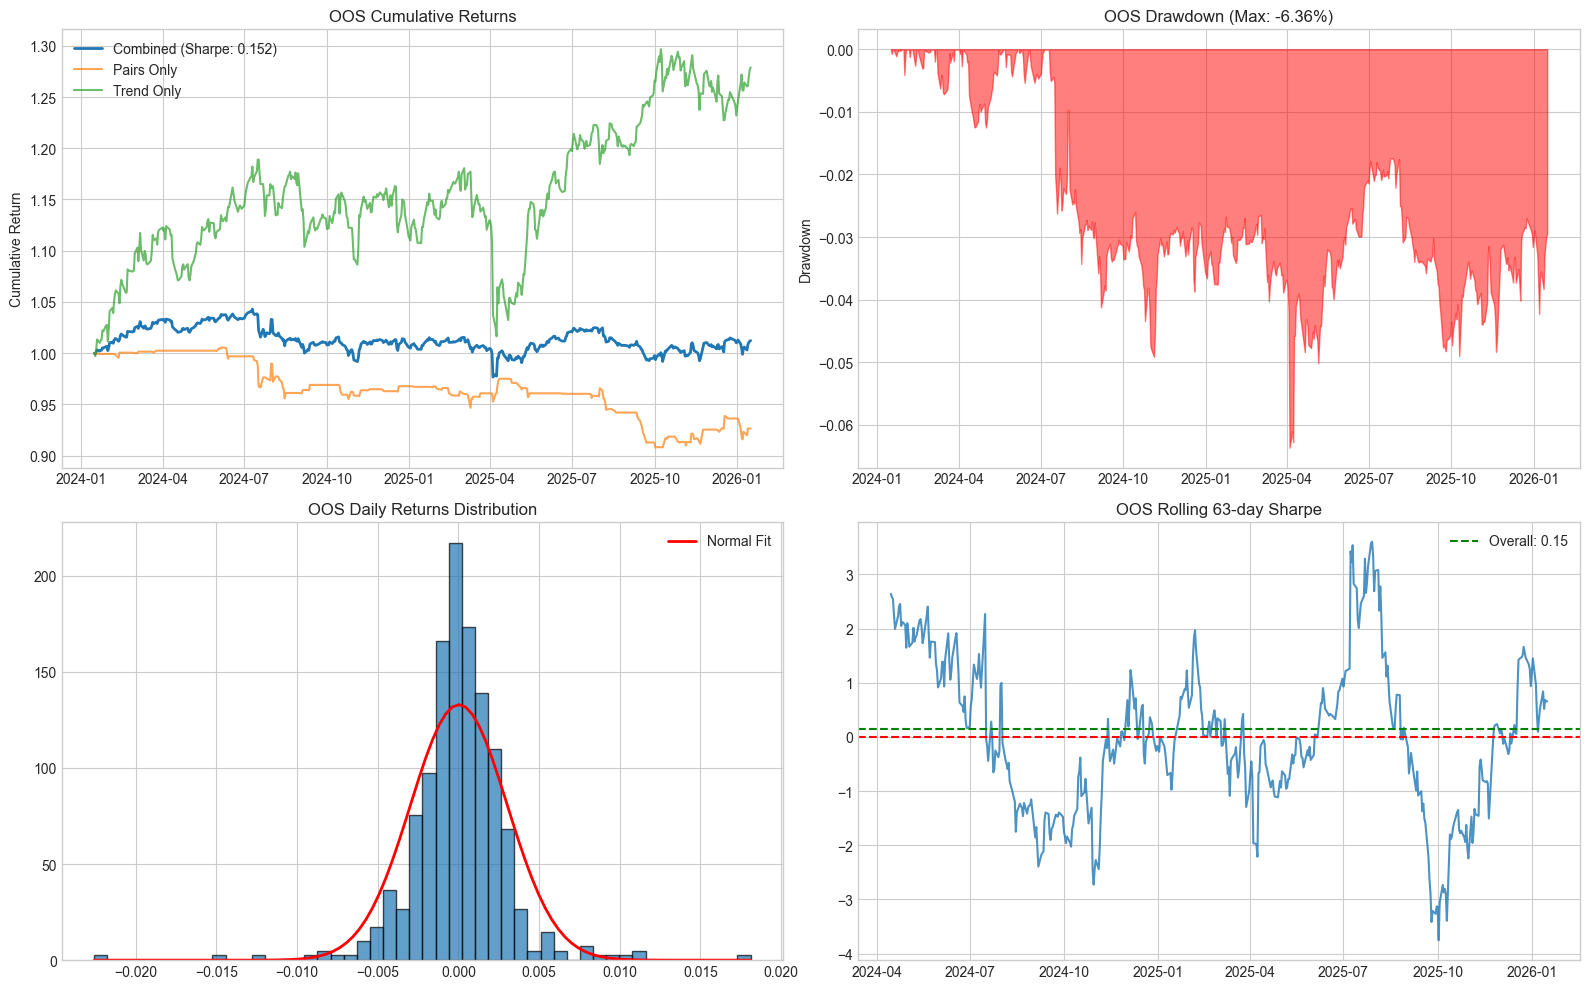

✅ Figure saved to outputs/figures/hybrid_portfolio_oos.png


In [19]:
# =============================================================================
# STEP 4 VISUALIZATION: COMBINED PORTFOLIO
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Cumulative Returns Comparison
ax1 = axes[0, 0]
pairs_cum = (1 + pairs_ret).cumprod()
trend_cum = (1 + trend_ret).cumprod()

ax1.plot(combined_cumulative, label=f'Combined (Sharpe: {combined_sharpe:.3f})', linewidth=2)
ax1.plot(pairs_cum, label=f'Pairs Only', alpha=0.7)
ax1.plot(trend_cum, label=f'Trend Only', alpha=0.7)
ax1.set_title('OOS Cumulative Returns')
ax1.legend()
ax1.set_ylabel('Cumulative Return')

# Plot 2: Drawdown
ax2 = axes[0, 1]
ax2.fill_between(drawdown.index, drawdown.values, 0, alpha=0.5, color='red')
ax2.set_title(f'OOS Drawdown (Max: {max_dd*100:.2f}%)')
ax2.set_ylabel('Drawdown')

# Plot 3: Daily Returns Distribution
ax3 = axes[1, 0]
ax3.hist(combined_return, bins=50, edgecolor='black', alpha=0.7, density=True)
x_norm = np.linspace(combined_return.min(), combined_return.max(), 100)
ax3.plot(x_norm, stats.norm.pdf(x_norm, combined_return.mean(), combined_return.std()), 
         'r-', linewidth=2, label='Normal Fit')
ax3.set_title('OOS Daily Returns Distribution')
ax3.legend()

# Plot 4: Rolling Sharpe
ax4 = axes[1, 1]
rolling_sharpe = combined_return.rolling(63).apply(
    lambda x: x.mean() / x.std() * np.sqrt(252) if x.std() > 0 else 0
)
ax4.plot(rolling_sharpe, alpha=0.8)
ax4.axhline(y=0, color='red', linestyle='--')
ax4.axhline(y=combined_sharpe, color='green', linestyle='--', 
            label=f'Overall: {combined_sharpe:.2f}')
ax4.set_title('OOS Rolling 63-day Sharpe')
ax4.legend()

plt.tight_layout()
plt.savefig('../../outputs/figures/hybrid_portfolio_oos.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure saved to outputs/figures/hybrid_portfolio_oos.png")

In [20]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("="*70)
print("NOTEBOOK 2: FINAL SUMMARY")
print("="*70)

print("""
📊 STRATEGY ARCHITECTURE
─────────────────────────────────────────────────────────────────────
Hybrid Strategy combining:
  Regime A: Kalman Filter Pairs Trading (Cointegrated Assets)
  Regime B: Momentum/Trend Strategy (Non-Cointegrated Assets)

Cointegration Analysis:
  - Engle-Granger two-step method
  - Bonferroni/FDR correction for multiple testing
  - Half-life filter for tradability

Kalman Pairs Trading:
  - Dynamic hedge ratio estimation
  - Z-score based entry/exit signals
  - Mean-reversion exploitation
""")

print(f"""
📈 PERFORMANCE SUMMARY
─────────────────────────────────────────────────────────────────────
Universe Allocation:
  Paired Assets:      {len(paired_assets)}
  Trend Assets:       {len(trend_assets)}

Individual Strategy OOS Sharpe:
  Pairs Strategy:     {pair_backtest_df['oos_sharpe'].mean():.4f}
  Trend Strategy:     {trend_sharpe_oos:.4f}

Combined Portfolio OOS:
  Net Sharpe:         {combined_sharpe:.4f}
  Total Return:       {combined_total_return*100:.2f}%
  Max Drawdown:       {max_dd*100:.2f}%
""")

print("""
💡 KEY INSIGHT
─────────────────────────────────────────────────────────────────────
"The Kalman Filter does not generate alpha by prediction alone; 
it structures uncertainty. Alpha emerges only when state uncertainty, 
innovations, and regime separation are exploited correctly."

Cointegration-based pairs trading exploits MEAN REVERSION:
  - Spread deviations from equilibrium are temporary
  - Kalman Filter adapts hedge ratio to changing relationships
  - Z-score normalizes spread for entry/exit decisions

Trend strategy exploits MOMENTUM:
  - Non-cointegrated assets follow their own dynamics
  - Cross-sectional ranking identifies relative strength
  
Combining BOTH strategies provides diversification:
  - Different return drivers (mean reversion vs momentum)
  - Lower correlation between strategy returns
  - More stable overall performance
""")

print("="*70)
print("END OF NOTEBOOK 2")
print("="*70)

NOTEBOOK 2: FINAL SUMMARY

📊 STRATEGY ARCHITECTURE
─────────────────────────────────────────────────────────────────────
Hybrid Strategy combining:
  Regime A: Kalman Filter Pairs Trading (Cointegrated Assets)
  Regime B: Momentum/Trend Strategy (Non-Cointegrated Assets)

Cointegration Analysis:
  - Engle-Granger two-step method
  - Bonferroni/FDR correction for multiple testing
  - Half-life filter for tradability

Kalman Pairs Trading:
  - Dynamic hedge ratio estimation
  - Z-score based entry/exit signals
  - Mean-reversion exploitation


📈 PERFORMANCE SUMMARY
─────────────────────────────────────────────────────────────────────
Universe Allocation:
  Paired Assets:      10
  Trend Assets:       90

Individual Strategy OOS Sharpe:
  Pairs Strategy:     -0.3643
  Trend Strategy:     0.9533

Combined Portfolio OOS:
  Net Sharpe:         0.1515
  Total Return:       1.22%
  Max Drawdown:       -6.36%


💡 KEY INSIGHT
─────────────────────────────────────────────────────────────────────
